In [1]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from typing import Tuple, Optional, Any
import math
from torch import Tensor
from einops import rearrange
from diffusers import DDPMScheduler
from torchvision import transforms, datasets
from tqdm import tqdm
from IPython.display import clear_output
import einops
from torch.utils.data.dataset import Dataset
from dataclasses import dataclass
from typing import List, Union, Dict, Any, Optional, BinaryIO
from PIL import Image, ImageColor, ImageDraw, ImageFont
import abc  # Abstract base class
import numpy as np
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import DDPMScheduler, DDPMPipeline
from diffusers.models.unets.unet_2d_condition import UNet2DConditionModel
from diffusers import DDPMScheduler, DDPMPipeline
from diffusers import DDPMScheduler, DDPMPipeline


In [2]:
# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Custom UNet2DConditionModel with reduced parameters
class CustomUNet2DConditionModel(UNet2DConditionModel):
    def __init__(self, **kwargs):
        super().__init__(
            sample_size=28,
            in_channels=1,
            out_channels=1,
            layers_per_block=2,  # Reduced from default
            block_out_channels=(32, 64, 64, 32),  # Reduced from default
            down_block_types=(
                "DownBlock2D",
                "CrossAttnDownBlock2D",
                "CrossAttnDownBlock2D",
                "DownBlock2D",
            ),
            up_block_types=(
                "UpBlock2D",
                "CrossAttnUpBlock2D",
                "CrossAttnUpBlock2D",
                "UpBlock2D",
            ),
            cross_attention_dim=512,  # CLIP embedding dimension
            **kwargs
        )

# Load models
unet = CustomUNet2DConditionModel().to(device)


In [3]:
# vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae").to(device)
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")

# Freeze VAE and text encoder
# vae.requires_grad_(False)
## set requires_grad_ to true so that the text_enocder aka CLIP model is also trained.
text_encoder.requires_grad_(False)
# tokenizer.requires_grad_(False)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

CLIPTextModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e

In [4]:
tokenizer.model_max_length ## 77

77

In [5]:
TOKENIZER_MAX_LENGTH = 8
captions_sample = ['"A handwritten digit 1']
text_input = tokenizer(captions_sample, padding="max_length", max_length=TOKENIZER_MAX_LENGTH, truncation=True, return_tensors="pt")
text_encoder(text_input.input_ids.to(device))[0].shape

## the following output is the size of the text embedding for one text prompt.

torch.Size([1, 8, 512])

In [6]:
num_of_params = sum([p.numel() for p in unet.parameters()])
print("Number of trainable parameters in the model: " + str(f"{num_of_params:,}"))

Number of trainable parameters in the model: 3,140,385


In [7]:
path_to_dataset = "../../datasets"

mnist_dataset = torchvision.datasets.MNIST(root=path_to_dataset, download=True, transform=transforms.ToTensor())

noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule="squaredcos_cap_v2")
train_dataloader = DataLoader(mnist_dataset, batch_size=512, shuffle=True)
next(iter(train_dataloader))[0].shape



  0%|          | 0.00/9.91M [00:00<?, ?B/s]
  0%|          | 32.8k/9.91M [00:00<01:09, 142kB/s]
  1%|          | 65.5k/9.91M [00:00<01:06, 149kB/s]
  1%|▏         | 131k/9.91M [00:00<00:44, 220kB/s] 
  3%|▎         | 295k/9.91M [00:00<00:22, 430kB/s]
  5%|▌         | 524k/9.91M [00:00<00:11, 791kB/s]
  7%|▋         | 655k/9.91M [00:01<00:10, 879kB/s]
  9%|▉         | 885k/9.91M [00:01<00:07, 1.17MB/s]
 11%|█         | 1.11M/9.91M [00:01<00:06, 1.39MB/s]
 13%|█▎        | 1.31M/9.91M [00:01<00:05, 1.51MB/s]
 15%|█▌        | 1.51M/9.91M [00:01<00:05, 1.62MB/s]
 18%|█▊        | 1.74M/9.91M [00:01<00:04, 1.74MB/s]
 20%|█▉        | 1.97M/9.91M [00:01<00:04, 1.89MB/s]
 41%|████      | 4.03M/9.91M [00:01<00:00, 5.88MB/s]
 58%|█████▊    | 5.77M/9.91M [00:02<00:00, 6.82MB/s]
100%|██████████| 9.91M/9.91M [00:02<00:00, 4.10MB/s]

  0%|          | 0.00/28.9k [00:00<?, ?B/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 135kB/s]

  0%|          | 0.00/1.65M [00:00<?, ?B/s]
  2%|▏         | 32.8k/1.65M

torch.Size([512, 1, 28, 28])

In [8]:
# Training parameters
# num_epochs = 100
num_epochs = 1
# learning_rate = 1e-4
learning_rate = 1e-3
optimizer = torch.optim.AdamW(unet.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    for batch in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, labels = batch
        images = images.to(device)

        # Create text captions from labels
        captions = [f"A handwritten digit {label}" for label in labels]

        # Encode images
        # latents = vae.encode(images).latent_dist.sample()
        # latents = latents * 0.18215 ## vae scale factor
        latents = images

        # Encode text
        text_input = tokenizer(captions, padding="max_length", max_length=TOKENIZER_MAX_LENGTH, truncation=True, return_tensors="pt")
        text_embeddings = text_encoder(text_input.input_ids.to(device))[0]

        # Add noise to latents
        noise = torch.randn_like(latents)
        timesteps = torch.randint(0, 1000, (latents.shape[0],), device=device).long()
        noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

        # Predict noise
        noise_pred = unet(noisy_latents, timesteps, encoder_hidden_states=text_embeddings).sample

        # Calculate loss
        loss = torch.nn.functional.mse_loss(noise_pred, noise)

        # Backpropagate and optimize
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")

Epoch 1/1: 100%|██████████| 118/118 [02:31<00:00,  1.28s/it]

Epoch 1/1, Loss: 0.04477057605981827


In [9]:
num_epochs=5
steps= 0
for epoch in range(num_epochs):
    for batch in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, labels = batch
        images = images.to(device)

        # Create text captions from labels
        captions = [f"A handwritten digit {label}" for label in labels]

        # Encode images
        # latents = vae.encode(images).latent_dist.sample()
        # latents = latents * 0.18215 ## vae scale factor
        latents = images

        # Encode text
        text_input = tokenizer(captions, padding="max_length", max_length=TOKENIZER_MAX_LENGTH, truncation=True, return_tensors="pt")
        text_embeddings = text_encoder(text_input.input_ids.to(device))[0]

        # Add noise to latents
        noise = torch.randn_like(latents)
        timesteps = torch.randint(0, 1000, (latents.shape[0],), device=device).long()
        noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

        # Predict noise
        noise_pred = unet(noisy_latents, timesteps, encoder_hidden_states=text_embeddings).sample

        # Calculate loss
        loss = torch.nn.functional.mse_loss(noise_pred, noise)
        steps = steps+1
        if (steps%25==0):
          print(f"steps {steps}, Loss: {loss.item()}")
        # Backpropagate and optimize
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")

Epoch 1/5:  20%|██        | 24/118 [00:30<01:58,  1.26s/it]

steps 25, Loss: 0.043283723294734955


Epoch 1/5:  42%|████▏     | 49/118 [01:01<01:26,  1.26s/it]

steps 50, Loss: 0.0407077930867672


Epoch 1/5:  63%|██████▎   | 74/118 [01:33<00:55,  1.26s/it]

steps 75, Loss: 0.04060912877321243


Epoch 1/5:  84%|████████▍ | 99/118 [02:04<00:24,  1.28s/it]

steps 100, Loss: 0.03628801181912422


Epoch 1/5: 100%|██████████| 118/118 [02:28<00:00,  1.25s/it]


Epoch 1/5, Loss: 0.04686543717980385


Epoch 2/5:   5%|▌         | 6/118 [00:07<02:19,  1.25s/it]

steps 125, Loss: 0.03994312882423401


Epoch 2/5:  26%|██▋       | 31/118 [00:38<01:49,  1.26s/it]

steps 150, Loss: 0.038596224039793015


Epoch 2/5:  47%|████▋     | 56/118 [01:10<01:17,  1.26s/it]

steps 175, Loss: 0.03710966184735298


Epoch 2/5:  69%|██████▊   | 81/118 [01:42<00:46,  1.26s/it]

steps 200, Loss: 0.033192310482263565


Epoch 2/5:  90%|████████▉ | 106/118 [02:13<00:15,  1.27s/it]

steps 225, Loss: 0.03351325914263725


Epoch 2/5: 100%|██████████| 118/118 [02:28<00:00,  1.26s/it]


Epoch 2/5, Loss: 0.039514053612947464


Epoch 3/5:  11%|█         | 13/118 [00:16<02:11,  1.26s/it]

steps 250, Loss: 0.03179951384663582


Epoch 3/5:  32%|███▏      | 38/118 [00:47<01:41,  1.27s/it]

steps 275, Loss: 0.033776573836803436


Epoch 3/5:  53%|█████▎    | 63/118 [01:19<01:10,  1.28s/it]

steps 300, Loss: 0.03425757586956024


Epoch 3/5:  75%|███████▍  | 88/118 [01:51<00:37,  1.26s/it]

steps 325, Loss: 0.034710947424173355


Epoch 3/5:  96%|█████████▌| 113/118 [02:22<00:06,  1.27s/it]

steps 350, Loss: 0.03018505871295929


Epoch 3/5: 100%|██████████| 118/118 [02:28<00:00,  1.26s/it]


Epoch 3/5, Loss: 0.03056483343243599


Epoch 4/5:  17%|█▋        | 20/118 [00:25<02:03,  1.26s/it]

steps 375, Loss: 0.03279229626059532


Epoch 4/5:  38%|███▊      | 45/118 [00:56<01:32,  1.27s/it]

steps 400, Loss: 0.03157564997673035


Epoch 4/5:  59%|█████▉    | 70/118 [01:28<01:00,  1.26s/it]

steps 425, Loss: 0.029199331998825073


Epoch 4/5:  81%|████████  | 95/118 [01:59<00:28,  1.26s/it]

steps 450, Loss: 0.03257034718990326


Epoch 4/5: 100%|██████████| 118/118 [02:28<00:00,  1.26s/it]


Epoch 4/5, Loss: 0.027013540267944336


Epoch 5/5:   2%|▏         | 2/118 [00:02<02:17,  1.19s/it]

steps 475, Loss: 0.031046735122799873


Epoch 5/5:  23%|██▎       | 27/118 [00:33<01:54,  1.26s/it]

steps 500, Loss: 0.0293075293302536


Epoch 5/5:  44%|████▍     | 52/118 [01:05<01:23,  1.27s/it]

steps 525, Loss: 0.02834557369351387


Epoch 5/5:  65%|██████▌   | 77/118 [01:37<00:51,  1.26s/it]

steps 550, Loss: 0.03058759495615959


Epoch 5/5:  86%|████████▋ | 102/118 [02:08<00:20,  1.26s/it]

steps 575, Loss: 0.030655331909656525


Epoch 5/5: 100%|██████████| 118/118 [02:28<00:00,  1.26s/it]

Epoch 5/5, Loss: 0.03008553758263588


/tmp/ipython-input-13-516014115.py:18: FutureWarning: Accessing config attribute `in_channels` directly via 'CustomUNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'CustomUNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((1, unet.in_channels, 28, 28)).to(device)
100%|██████████| 50/50 [00:02<00:00, 24.90it/s]


torch.Size([1, 1, 28, 28])


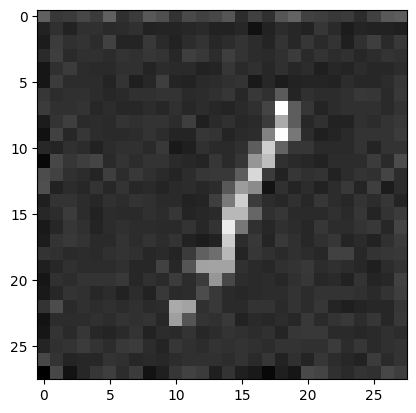

In [13]:
# Set models to evaluation mode
# vae.eval()
text_encoder.eval()
unet.eval()

# Inference parameters
num_inference_steps = 50
# guidance_scale = 100

@torch.no_grad()
def generate_image(prompt):
    # Tokenize and encode the text prompt
    text_input = tokenizer(prompt, padding="max_length", max_length=TOKENIZER_MAX_LENGTH, truncation=True, return_tensors="pt")
    text_embeddings = text_encoder(text_input.input_ids.to(device))[0]

    # Initialize latents / create noisy image.
    torch.manual_seed(422)  # Set the seed
    latents = torch.randn((1, unet.in_channels, 28, 28)).to(device)

    # Denoise scheduler
    scheduler = DDPMScheduler(beta_schedule="squaredcos_cap_v2", num_train_timesteps=1000)
    scheduler.set_timesteps(num_inference_steps)

    # Denoising loop
    for t in tqdm(scheduler.timesteps):
        # Prepare latent model input
        latent_model_input = scheduler.scale_model_input(latents, t)

        # Predict noise residual
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

        # Compute previous noisy sample
        latents = scheduler.step(noise_pred, t, latents).prev_sample

    # # Decode latents to image
    # latents = 1 / 0.18215 * latents
    # image = vae.decode(latents).sample
    image=latents
    print (image.shape)
    # Post-process image ## i.e reverse the normalization
    image = (image / 2 + 0.5).clamp(0, 1)
    # image = image.cpu().permute(0, 2, 3, 1).numpy()
    # image = (image * 255).round().astype("uint8")
    return image

# Generate an image
prompt = "A handwritten digit 4"
generated_image = generate_image(prompt)

# Display or save the image
image = generated_image[0]  # Remove the extra dimension
image = image.squeeze(0)
image = image.detach().cpu().numpy()  # Remove batch dimension
# image = image.unsqueeze(-1)  # Add a new dimension for color channels
image = (image * 255).round().astype("uint8")
import matplotlib.pyplot as plt

# Assuming generated_image is the tensor you want to view
# image = generated_image[0].detach().cpu().numpy()  # Remove batch dimension
# image = image.unsqueeze(-1)  # Add a new dimension for color channels
plt.imshow(image, cmap='gray')  # Display as grayscale image
plt.show()

In [ ]:
## save unet and text_encoder
# Save the trained model
# torch.save(unet.state_dict(), "./unet.pth")


/tmp/ipython-input-15-133456894.py:25: FutureWarning: Accessing config attribute `in_channels` directly via 'CustomUNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'CustomUNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((num_images, unet.in_channels, 28, 28)).to(device)
100%|██████████| 50/50 [00:02<00:00, 20.28it/s]

torch.Size([1, 1, 28, 28])


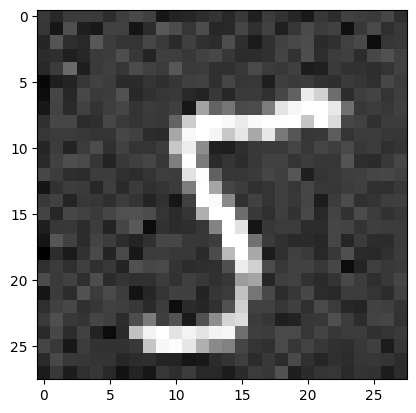

In [15]:
# Set models to evaluation mode
# vae.eval()
# text_encoder.eval()
unet.eval()

# Inference parameters
num_inference_steps = 50
guidance_scale = 8

@torch.no_grad()
def generate_image(prompt, num_images=1):
    # Tokenize and encode the text prompt
    text_input = tokenizer(prompt, padding="max_length", max_length=TOKENIZER_MAX_LENGTH, truncation=True, return_tensors="pt")
    text_embeddings = text_encoder(text_input.input_ids.to(device))[0]

    # Prepare unconditioned embeddings for classifier free guidance
    max_length = text_input.input_ids.shape[-1]
    uncond_input = tokenizer([""] * num_images, padding="max_length", max_length=TOKENIZER_MAX_LENGTH, return_tensors="pt")
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(device))[0]

    # Concatenate text embeddings with unconditional embeddings
    text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

    # Initialize latents
    latents = torch.randn((num_images, unet.in_channels, 28, 28)).to(device)

    # Denoise scheduler
    scheduler = DDPMScheduler(beta_schedule="squaredcos_cap_v2", num_train_timesteps=1000)
    scheduler.set_timesteps(num_inference_steps)

    for t in tqdm(scheduler.timesteps):
        # Expand latents for classifier free guidance
        latent_model_input = torch.cat([latents] * 2)
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)
        # Predict noise residual
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

        # Perform guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # Compute previous noisy sample
        latents = scheduler.step(noise_pred, t, latents).prev_sample

    # # Decode latents to image
    # latents = 1 / 0.18215 * latents
    # image = vae.decode(latents).sample
    image=latents
    print (image.shape)
    # Post-process image
    image = (image / 2 + 0.5).clamp(0, 1)
    # image = image.cpu().permute(0, 2, 3, 1).numpy()
    # image = (image * 255).round().astype("uint8")
    return image

# Generate an image
prompt = "A handwritten digit 5"
generated_images = generate_image(prompt)

# Display or save the image
image = generated_images[0]  # Remove the extra dimension
image = image.squeeze(0)
image = image.detach().cpu().numpy()  # Remove batch dimension
# image = image.unsqueeze(-1)  # Add a new dimension for color channels
image = (image * 255).round().astype("uint8")
import matplotlib.pyplot as plt

# Assuming generated_image is the tensor you want to view
# image = generated_image[0].detach().cpu().numpy()  # Remove batch dimension
# image = image.unsqueeze(-1)  # Add a new dimension for color channels
plt.imshow(image, cmap='gray')  # Display as grayscale image
plt.show()


/tmp/ipython-input-15-133456894.py:25: FutureWarning: Accessing config attribute `in_channels` directly via 'CustomUNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'CustomUNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((num_images, unet.in_channels, 28, 28)).to(device)
100%|██████████| 50/50 [00:01<00:00, 31.33it/s]


torch.Size([1, 1, 28, 28])


100%|██████████| 50/50 [00:01<00:00, 29.71it/s]


torch.Size([1, 1, 28, 28])


100%|██████████| 50/50 [00:02<00:00, 24.98it/s]


torch.Size([1, 1, 28, 28])


100%|██████████| 50/50 [00:01<00:00, 32.17it/s]


torch.Size([1, 1, 28, 28])


100%|██████████| 50/50 [00:01<00:00, 31.99it/s]


torch.Size([1, 1, 28, 28])


100%|██████████| 50/50 [00:01<00:00, 32.50it/s]


torch.Size([1, 1, 28, 28])


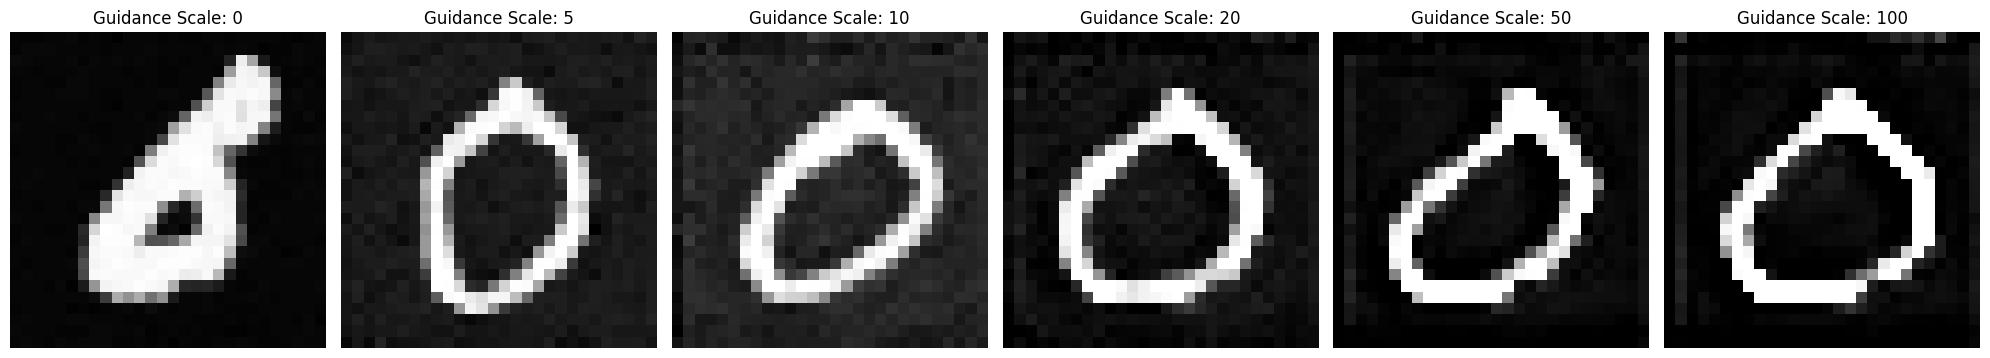

In [16]:
# Define the guidance scale values
guidance_scales = [0, 5, 10, 20, 50, 100]

# Initialize a figure with a grid of subplots
fig, axs = plt.subplots(nrows=1, ncols=len(guidance_scales), figsize=(20, 4))

# Generate an image for each guidance scale value
for i, guidance_scale in enumerate(guidance_scales):
    # Set the guidance scale
    # global guidance_scale
    # guidance_scale = guidance_scale

    # Generate an image
    prompt = "A handwritten digit 0"
    generated_image = generate_image(prompt)

    # Display or save the image
    image = generated_image[0]  # Remove the extra dimension
    image = image.squeeze(0)
    image = image.detach().cpu().numpy()  # Remove batch dimension
    image = (image * 255).round().astype("uint8")

    # Display the image in the current subplot
    axs[i].imshow(image, cmap='gray')  # Display as grayscale image
    axs[i].set_title(f'Guidance Scale: {guidance_scale}')
    axs[i].axis('off')

# Layout so plots do not overlap
fig.tight_layout()

# Display the plot
plt.show()